In [ ]:
import json
import requests
from datetime import datetime, timezone
import time

new_extensions = []
new_versions = []

filename = 'extensions.json'
with open(filename) as f:
    extensions = json.load(f)

# Get the current time in UTC
now_utc = datetime.now(timezone.utc)
# Format the datetime object as a string
current_date_time = now_utc.strftime('%Y-%m-%dT%H:%M:%S.%fZ')

def get_url(url):
    retry_count = 0
    retry_delay = 0.5
    results = None
    while retry_count < 20:
        try:
            response = requests.get(url, timeout=5)
            results = response.json()
            break
        except Exception as e:
            print(f"Failed to get {url}. Retrying after {retry_delay} seconds.")
            retry_count += 1
            time.sleep(retry_delay)
            retry_delay = retry_delay * 2
    return results

count = 0
for extension in extensions:
    first_release = current_date_time
    for version_key in extension['allVersions'].keys():
        if version_key != 'latest' and version_key != 'pre-release':
            version_url = extension['allVersions'][version_key]
            version_results = get_url(version_url)
            if version_results is not None and version_results.get('error') is None:
                new_versions.append(version_results['timestamp'])
                if version_results['timestamp'] < first_release:
                    first_release = version_results['timestamp']
    new_extensions.append(first_release)
    count += 1
    print(f"Processed {len(extension['allVersions'].keys())} versions for {extension['name']} - {count} of {len(extensions)}: {len(new_extensions)} - {len(new_versions)}")

In [2]:
print(f"Length new extensions: {len(new_extensions)}")
print(f"Length new versions: {len(new_versions)}")

Length new extensions: 6229
Length new versions: 65529


In [ ]:
def write_events_to_file(events, filename):
    """
    Writes a list of event datetime strings to a JSON file.

    Args:
        events (list): A list of datetime strings.
        filename (str): The name of the file to save to.
    """
    try:
        with open(filename, 'w') as f:
            json.dump(events, f, indent=4)
        print(f"Successfully wrote {len(events)} events to {filename}")
    except IOError as e:
        print(f"Error writing to file: {e}")

def read_events_from_file(filename):
    """
    Reads a list of event datetime strings from a JSON file.

    Returns:
        list: The list of datetime strings.
    """
    try:
        with open(filename, 'r') as f:
            events = json.load(f)
        print(f"Successfully read {len(events)} events from {filename}")
        return events
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return []
    except json.JSONDecodeError:
        print(f"Error decoding JSON from file: {filename}")
        return []

NEW_VERSIONS_FILE_NAME = 'new_versions.json'
NEW_EXTENSIONS_FILE_NAME = 'new_extensions.json'

write_events_to_file(new_versions, NEW_VERSIONS_FILE_NAME)
write_events_to_file(new_extensions, NEW_EXTENSIONS_FILE_NAME)
versions = read_events_from_file(NEW_VERSIONS_FILE_NAME)
extensions = read_events_from_file(NEW_EXTENSIONS_FILE_NAME)
print(len(versions))
print(len(extensions))

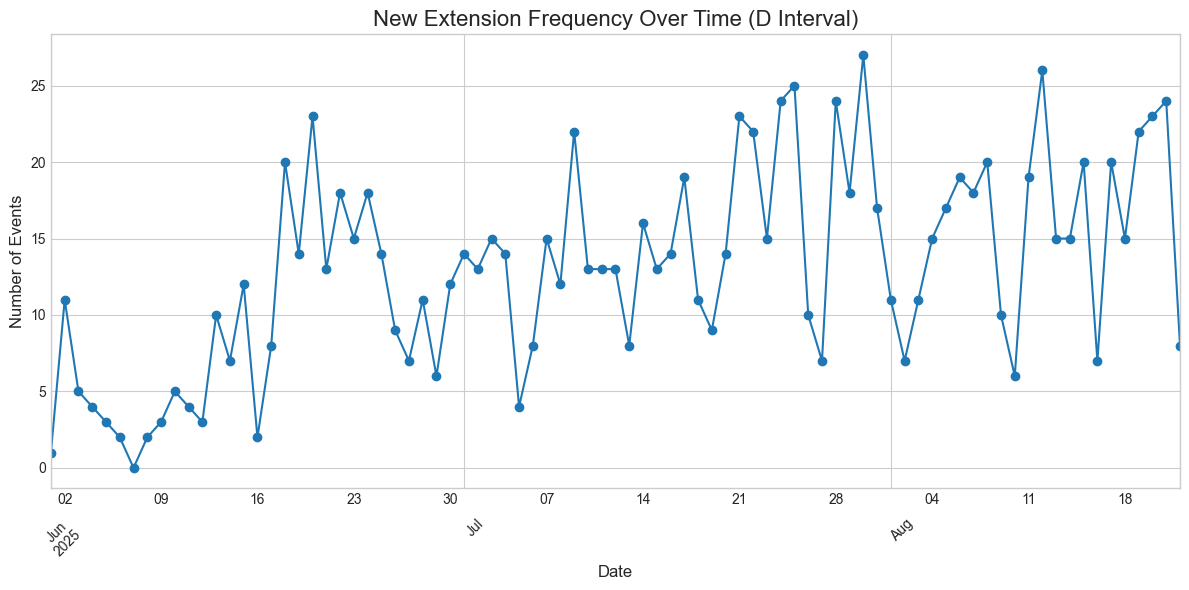

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the list of strings into a pandas DataFrame.
new_extensions_df = pd.DataFrame(extensions, columns=['extension_datetime_string'])
# Use pd.to_datetime to convert the string column to a proper datetime format.
new_extensions_df['extension_datetime'] = pd.to_datetime(new_extensions_df['extension_datetime_string'])
# Set the datetime column as the DataFrame's index. This is crucial for time-series analysis with pandas.
new_extensions_df.set_index('extension_datetime', inplace=True)

# The reporting interval. Common options include:
# 'S' - seconds, 'T' - minutes, 'H' - hours, 'D' - days, 'W' - weeks, 'M' - months, 'Q' - quarters, 'Y' - years.
reporting_interval = 'D'
# The time span to plot. This filters the data to a specific range. Format as 'YYYY-MM-DD' strings.
start_date = '2025-06-01'
end_date = '2025-08-22'
new_extensions_event_frequency = new_extensions_df['extension_datetime_string'].resample(reporting_interval).count()
new_extensions_filtered_frequency = new_extensions_event_frequency.loc[start_date:end_date]

# Plot the results
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))
new_extensions_filtered_frequency.plot(kind='line', marker='o', linestyle='-')
plt.title(f'New Extension Frequency Over Time ({reporting_interval} Interval)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.xticks(rotation=45) # Rotate x-axis labels for readability.
plt.grid(True)
plt.tight_layout() # Adjust plot to ensure everything fits.
plt.show()

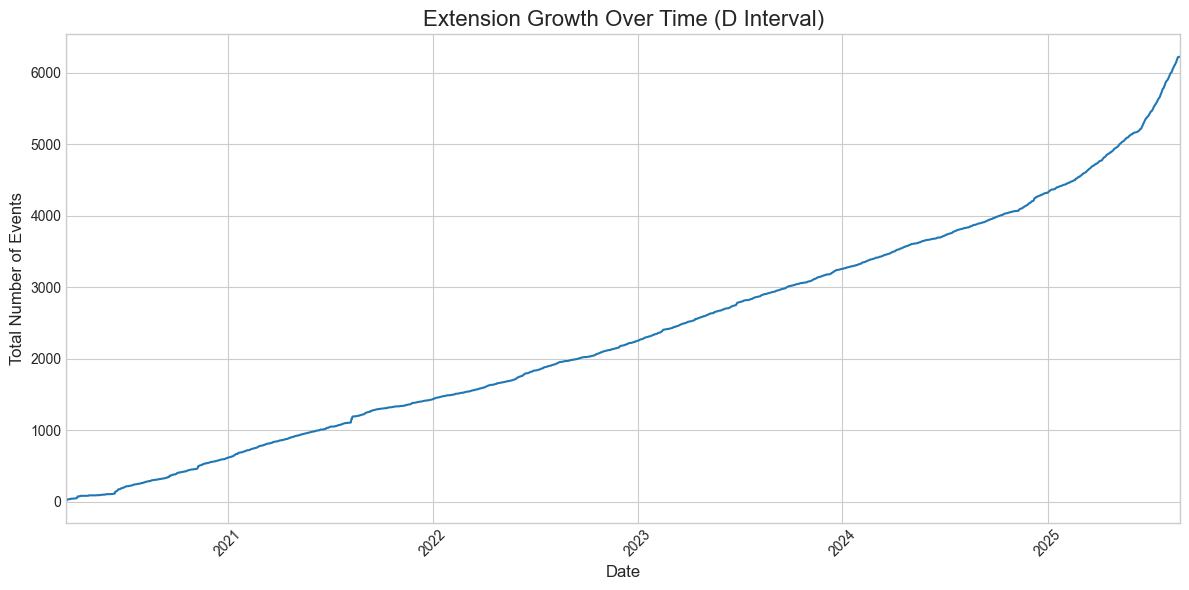

In [10]:
start_date = '2020-01-01'
end_date = '2025-08-31'

# Filter the resampled data to the desired time span.
total_new_extensions_filtered_frequency = new_extensions_event_frequency.loc[start_date:end_date]
# Calculate the cumulative sum of the filtered frequency.
cumulative_new_extensions = total_new_extensions_filtered_frequency.cumsum()


plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))
cumulative_new_extensions.plot(kind='line', linestyle='-')
plt.title(f'Extension Growth Over Time ({reporting_interval} Interval)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Number of Events', fontsize=12)
plt.xticks(rotation=45) # Rotate x-axis labels for readability.
plt.grid(True)
plt.tight_layout() # Adjust plot to ensure everything fits.
plt.show()

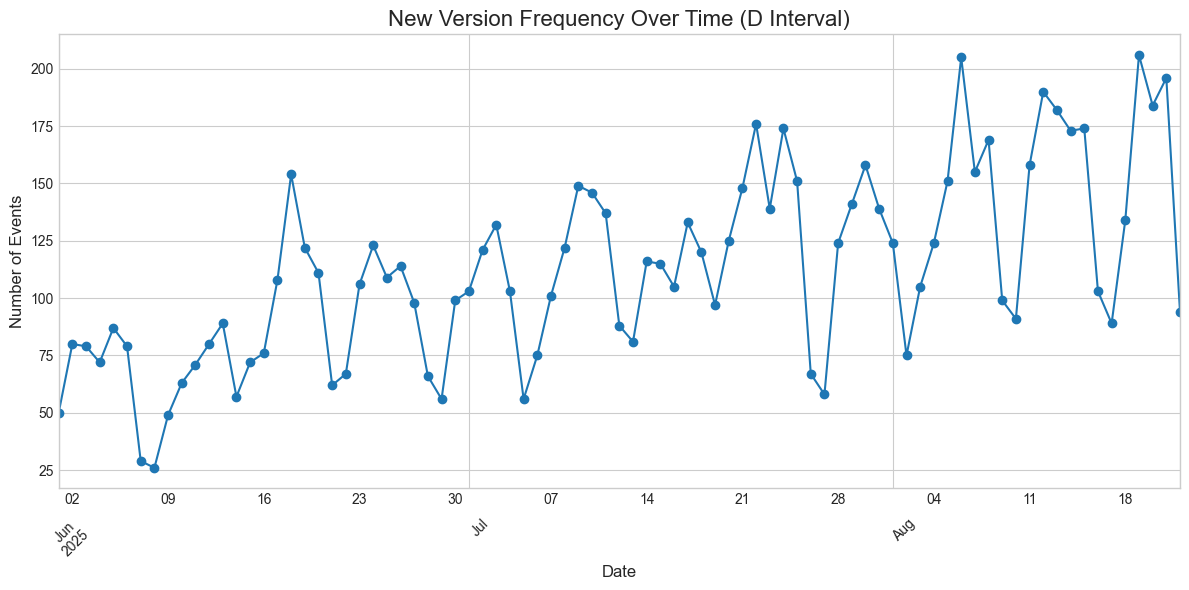

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# Convert the list of strings into a pandas DataFrame.
new_versions_df = pd.DataFrame(versions, columns=['version_datetime_string'])
# Use pd.to_datetime to convert the string column to a proper datetime format.
new_versions_df['version_datetime'] = pd.to_datetime(new_versions_df['version_datetime_string'])
# Set the datetime column as the DataFrame's index. This is crucial for time-series analysis with pandas.
new_versions_df.set_index('version_datetime', inplace=True)
# The reporting interval. Common options include:
# 'S' - seconds, 'T' - minutes, 'H' - hours, 'D' - days, 'W' - weeks, 'M' - months, 'Q' - quarters, 'Y' - years.
reporting_interval = 'D'
# The time span to plot. This filters the data to a specific range. Format as 'YYYY-MM-DD' strings.
start_date = '2025-06-01'
end_date = '2025-08-22'

new_versions_event_frequency = new_versions_df['version_datetime_string'].resample(reporting_interval).count()
new_versions_filtered_frequency = new_versions_event_frequency.loc[start_date:end_date]

# Plot the results
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))
new_versions_filtered_frequency.plot(kind='line', marker='o', linestyle='-')
plt.title(f'New Version Frequency Over Time ({reporting_interval} Interval)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.xticks(rotation=45) # Rotate x-axis labels for readability.
plt.grid(True)
plt.tight_layout() # Adjust plot to ensure everything fits.
plt.show()

In [1]:
import nbformat
from nbconvert import HTMLExporter

# Load the notebook
with open("openvsx_publishing.ipynb") as f:
    notebook = nbformat.read(f, as_version=4)

# Instantiate the exporter
html_exporter = HTMLExporter()

# Convert the notebook to HTML
(body, resources) = html_exporter.from_notebook_node(notebook)

# Save the HTML to a file
with open("openvsx_publishing.html", "w") as f:
    f.write(body)